# Milestone 2 Report: Robot Localization with Kalman Filters
Noah Mollerstuen

## Objective
The objective of this project is to explore the applications of probabilistic modelling to robotics. Specifically, I want to understand how probabilistic models can help a robot determine the state of its environment in the presence of conflicting measurements and uncertainties. I plan to develop a simulation of a two-dimensional mobile robot that will illustrate these principles.

## Background
Many systems in robotics are dynamical, i.e. they change over time. For example, the position and velocity of the robot may change over time as the robot moves around and changes direction. The true state of the system (i.e. the true position of the robot) is often unknown, but various sensors may be used to gain information about the state of the system. Robots might use GPS, accelerometers, measure wheel rotations, etc. However, each of these measurements is uncertain. GPS may only be accurate to within 10 meters, and other measurements may drift over time. The problem then, is how to combine the various uncertain information available to the robot to optimally update its beliefs about the state of the system.

## Kalman filters
A Kalman filter is a model for predicting the state of a dynamic (changing over time) system based on uncertain measurements. One of the articles I read used the example of a radar tracking an aircraft's position in one dimension, so I simulated that scenario to understand how Kalman filters work. Below are the steps to implement a Kalman filter in Python.

### 1. Define the state space
The first thing we need to do is define the variables that represent the "hidden states" of the system that we're trying to measure. In the simple example of an aircraft moving in one dimension, I chose the aircraft's position and velocity. You should choose choose these variables so that as time passes, you can predict how each variable will change based on the values of the other variables (in this case, the change in position can be calculated based on the velocity). In systems engineering, this is called a state space model.

In [53]:
from dataclasses import dataclass

@dataclass
class State:
    plane_pos: float
    plane_vel: float

### Radar system
Next we will model the sensors that will give information about the system. Kalman filters assume measurements are drawn from a gaussuan distribution, so I've simulated the radar by sampling from a gaussian distribution centered around the true position of the aircraft. Though in this case the sensor is directly measuring one of the state variables, it is also possible for kalman filters to interpret sensor measurements that are funcitons of multiple state variables. Note that this function is not a directly part of the kalman filter, it's used to generate the radar data that the kalman filter will interpret.

In [54]:
from scipy.stats import norm

RADAR_STD_DEV = 3e-3  # Meters


def measure_radar(state: State) -> float:
    measurement_dist = norm(loc=state.plane_pos, scale=RADAR_STD_DEV)
    return measurement_dist.rvs()


### Plane dynamics
To test the Kalman filter, we need to simulate the movement of a plane. For simplicity, we assume that plane's velocity is constant. This function calucalates the new state of the system (position and velocity) based on the previous state and the amount of time that's passed since the last update. This function is also used for testing the Kalman filter and is not part of the filter itself.

In [55]:
# def update_dynamics(timestep: float, last_state: State) -> State:
#     return State(
#         plane_pos=last_state.plane_pos + last_state.plane_vel * timestep,
#         plane_vel=last_state.plane_vel  # Constatnt velocity
#     )

import math

def update_dynamics(timestep: float, last_state: State, sim_time) -> State:
    return State(
        plane_pos=math.sin(sim_time),
        plane_vel=math.cos(sim_time)
    )

### Kalman filter
Finally we implement the Kalman filter itself. The filter has its own state. It includes the two state variables defined earlier, but also the variance of each state variable and the covariance between them. The vairance represents the model's certainty in its estimate of each variable, and the covariance represents the model's belief of the degree to which to two variables are correlated.

The filter consists of two main functions: predict() and process_measurement(). The predict function updates the model's beliefs about the state variables as time passes. This is based on our understanding of the system dynamics, and you can see the functions bear a strong resemblance to the update_dynamics() function used to simulate the system. I'm still looking for an intuitive explanation of the variance update equations. I think they may be better understood as matrix equations, which I plan to look into next.

The process_measurements() function updates the models beliefs based on new sensor measurements. It combines the model's prior belief distribution with the distribution of likely state variables based on the measurement. Since both are modelled as gaussians, this is acheived simply by multiplying the two gaussians together and normalizing. One effect worth noting is that the variance always decreases in this step - incorporating new measurements always reduces our uncertainty. 

In [56]:
import numpy as np

PROCESS_NOISE_VEL = 1e-3

class KalmanFilter:
    
    @dataclass
    class KalmanState:
        pos_mean: float
        pos_var: float
        vel_mean: float
        vel_var: float
        pos_vel_covar: float

    state: KalmanState

    def __init__(self, state: KalmanState):
        self.state = state
    
    def predict(self, timestep: float) -> None:
        """"Update beliefs due to the passasge of time"""

        new_pos_mean = self.state.pos_mean + self.state.vel_mean * timestep
        new_vel_mean = self.state.vel_mean

        new_pos_var = self.state.pos_var + timestep ** 2 * self.state.vel_var + 2 * timestep * self.state.pos_vel_covar
        new_vel_var = self.state.vel_var + PROCESS_NOISE_VEL
        new_cov = self.state.pos_vel_covar + timestep * self.state.vel_var

        self.state = self.KalmanState(
            pos_mean=new_pos_mean,
            pos_var=new_pos_var,
            vel_mean=new_vel_mean,
            vel_var=new_vel_var,
            pos_vel_covar=new_cov
        )
    

    def process_measurement(self, measurement: float, measurement_var: float) -> None:
        """Update beliefs when new measurements are made"""
        kalman_gain_pos = self.state.pos_var / (self.state.pos_var + measurement_var)
        kalman_gain_vel = self.state.pos_vel_covar / (self.state.pos_var + measurement_var)

        new_pos_mean = self.state.pos_mean + kalman_gain_pos * (measurement - self.state.pos_mean)
        new_vel_mean = self.state.vel_mean + kalman_gain_vel * (measurement - self.state.pos_mean)

        new_pos_var = self.state.pos_var - kalman_gain_pos * self.state.pos_var
        new_vel_var = self.state.vel_var - kalman_gain_vel * self.state.pos_vel_covar
        new_cov = self.state.pos_vel_covar - kalman_gain_vel * self.state.pos_var

        self.state = self.KalmanState(
            pos_mean = new_pos_mean,
            vel_mean = new_vel_mean,
            pos_var = new_pos_var,
            vel_var = new_vel_var,
            pos_vel_covar = new_cov,
        )


    def update(self, timestep: float, measurement: float, measurement_var: float) -> KalmanState:
        self.predict(timestep)

        self.process_measurement(measurement, measurement_var)

        return self.state

### Filter simulation
Finally, we can simulate the filter. We update the filter every time a new measurement becomes available. When we call the filter's update function, it first predicts the new state based on the time that's passed since the last update and then combines that prediction with the measurement.

In [57]:
SIMULATION_STEPS = 100
TIME_STEP = 0.05  # s
PLANE_VEL = 0  # m/s

system_state = State(
    0,  # Arbitrary starting position
    0
)

# Initialize Kalman filter with large variances to model uncertain starting conditions
filter = KalmanFilter(KalmanFilter.KalmanState(
    pos_mean=0,
    vel_mean=0,
    pos_var=1,
    vel_var=1,
    pos_vel_covar=0,
))

states = []
measurements = []
estimates = []

sim_time = 0.0

for _ in range(SIMULATION_STEPS):
    sim_time += TIME_STEP

    # Simulate dynamics
    system_state = update_dynamics(TIME_STEP, system_state, sim_time)
    states.append(system_state)

    # Simulate radar measurement
    measurement = measure_radar(system_state)
    measurements.append(measurement)

    # Apply Kalman filter
    # Assume radar variance is known
    state_estimate = filter.update(TIME_STEP, measurement, measurement_var=RADAR_STD_DEV ** 2)
    estimates.append(state_estimate)


### Results
To visualize the results, I plotted the predictions for position and velocity against their true values over time.

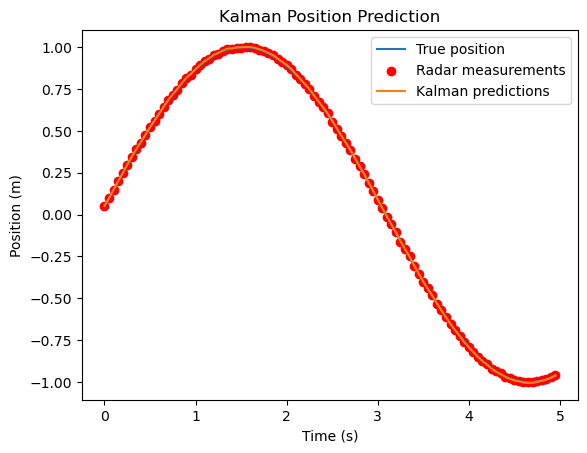

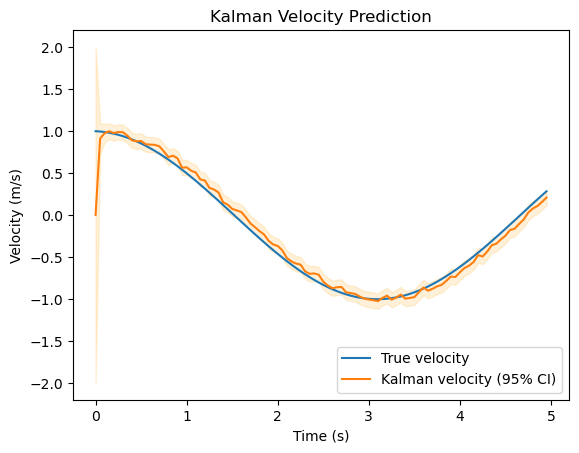

In [58]:
import matplotlib.pyplot as plt

# Plot results
t = np.arange(0, TIME_STEP * SIMULATION_STEPS, TIME_STEP)

plt.plot(t, [s.plane_pos for s in states], label="True position")
plt.scatter(t, measurements, c='r', label="Radar measurements")
plt.plot(t, [e.pos_mean for e in estimates], label="Kalman predictions")

plt.title("Kalman Position Prediction")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()

plt.figure()
plt.plot(t, [s.plane_vel for s in states], label="True velocity")
plt.plot(t, [e.vel_mean for e in estimates], label="Kalman velocity (95% CI)")


plt.fill_between(
    t,
    [e.vel_mean + 2 * np.sqrt(e.vel_var) for e in estimates],
    [e.vel_mean - 2 * np.sqrt(e.vel_var) for e in estimates],
    color='orange',
    alpha=0.15,
)

plt.title("Kalman Velocity Prediction")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend(loc="lower right")

The filter appears to be basically working, the position estimates follow the true position line, and are less noisy than the measurements, however the velocity prediction is noisy and uncertain (95% confidence interval calculated from the model's velocity variance).

### Challenges and Next Steps
The Kalman filter appears to be mergeing its predictions with the radar measurements and producing a reasonable estimate for position, which can be seen in the position plot. Its velocity prediction is also centered around the true value, but it takes a long time to converge. Intuitively, I think the model should have enough information to make a much more precise estimate of the velocity, since it assumes the velocity is constant. I'm unsure whether there's an issue with my implementation or there's a gap in my understanding affecting my intuition for the model's performance.

One limitaion with this model is it assumes the velocity of the plane never changes. The variance of the velocity can never increase, so the model will always become more and more confident in its velocity estimates. If the plane's velocity were to change, the new radar measurements would not significantly affect the predicted velocity, because the velocity variance had already collapsed. In the current simulation, this constant velocity assumption is true, so the model is able to make accurate predictions. One solution to allow the model to respond to disturbances not predicted by its state space equations, is to add a small amount of variance to each state variable every time step. I will test this idea with my next model.

Additionally, to apply the filter to problems with larger state spaces or multiple sensors, it would be helpful to reimplment the filter update rules in terms of matricies. This seems to be the standard representation for "real world" Kalman filter implementations. I would like to be able to simulate a robot in two dimensions, and predict its heading in addition to its position and velocity.

I am interested in feedback both on the technical aspects of the Kalman filter and on the presentation. What did you think of the notebook format? I think the filter is just about simple enough that showing all of the code might be reasonable, but let me know if it's distracing.